In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

In [4]:
df = pd.read_csv("/home/maxim/pozorniki/_data.csv", index_col=0)

In [5]:
#Переименовываем столбцы на латинские названия для избежания потенциальных ошибок

df.columns = ['ID', 'rooms', 'apt_type', 'metro', 'address',
       'apartment_sqm', 'floors_and_type', 'parking', 'price', 'tel', 'description',
       'style', 'rooms_sqm', 'balcony', 'window_view', 'bathroom_count',
       'kids_pets', 'utilities', 'building_name',
       'building_series', 'ceiling_height', 'elevator', 'trash',
       'cian link']

In [6]:

#делаем копию датасета на всякий случай, добавляем новый столбец с городом, фильтрует по МСК и убираем остальные города, т.к. задание подразумевает анализ исключительно в МСК

df2 = df.copy()
df2["city"] = df2["address"].apply(lambda x: (str(x).split(","))[0])
df2 = df2[df2["city"] == "Москва"]
df2.drop(columns=["city"], inplace=True)




In [7]:
#Смотрим общую информацию по таблице и на типы данных в столбцах
df2.info()
df2.dtypes

<class 'pandas.core.frame.DataFrame'>
Index: 19737 entries, 0 to 23367
Data columns (total 24 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               19737 non-null  int64  
 1   rooms            19202 non-null  object 
 2   apt_type         19737 non-null  object 
 3   metro            19391 non-null  object 
 4   address          19737 non-null  object 
 5   apartment_sqm    19737 non-null  object 
 6   floors_and_type  19737 non-null  object 
 7   parking          8563 non-null   object 
 8   price            19737 non-null  object 
 9   tel              19737 non-null  object 
 10  description      19737 non-null  object 
 11  style            17274 non-null  object 
 12  rooms_sqm        12509 non-null  object 
 13  balcony          13107 non-null  object 
 14  window_view      14587 non-null  object 
 15  bathroom_count   17696 non-null  object 
 16  kids_pets        14822 non-null  object 
 17  utilities        

ID                   int64
rooms               object
apt_type            object
metro               object
address             object
apartment_sqm       object
floors_and_type     object
parking             object
price               object
tel                 object
description         object
style               object
rooms_sqm           object
balcony             object
window_view         object
bathroom_count      object
kids_pets           object
utilities           object
building_name       object
building_series     object
ceiling_height     float64
elevator            object
trash               object
cian link           object
dtype: object

<Axes: >

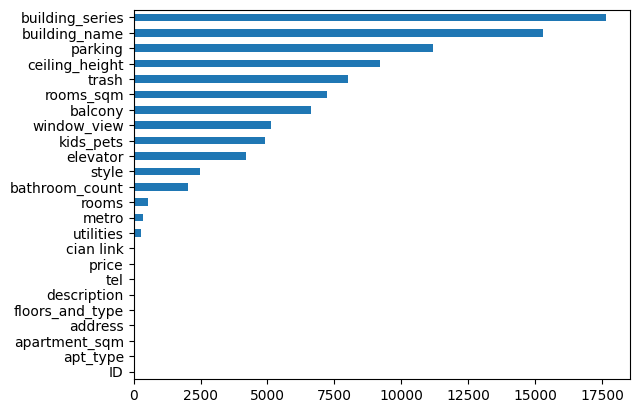

In [8]:
#проверяем на дубликаты данные

int(df2.duplicated().sum())

#Смотрим на заполненность столбцов и кол-во пустых ячеек в них
df2.isna().sum().sort_values().plot.barh()



In [9]:
#Анализируем столбцы с большим кол-ом пропусков на надобность в заполнении пустых ячеек
#Building Series & Building name - не нужны, никакой полезной информации они не несут
#Parking - потенциально важный показатель для анализа, пустые значения скорее всего означают отсутствие выделенной парковки и будут заполнены соответственным образом
#Ceiling height - возможно нужен. Пустые значения скорее всего просто не заполнялись при создании. 
#Возможно для анализа не будем использовать, в ином случае заполним как 2.5м (стандратной высотой квартир).
#Trash - просто похуй
#Rooms_sqm - показатель, который не стоит учитывать в анализе, т.к. слишком много пустых значений, которые могут быть абсолютно разные и применять средние будет нерелевантно
#Balcony - может сильно влиять на цену. Пропуски потенциально означают остуствие балкона, которые стоит заполнить нулями
#Window view - в пизду
#Kids_pets - не учитываем, т.к. единственный оставшийся вариант на циане: "не важно", что никак не дает понять наверняка можно ли с детьми или животными или нельзя.
#Elevator - не учитываем, т.к. даже в заполненных полях на одинаковых адресах присутствуют разные данные, что только ведут к некорректности
#Style - ремонт важен. оставляем
#Bathroom_count - важно, пустые заполним как 1



In [10]:
def convert_price(n):
    x = n.split()
    if '$' in x[1]:
        return float(x[0])*80
    if '€' in n.split()[1]:
        return float(x[0])*100
    else:
        return float(x[0])

df2['price_RUR'] = df2['price'].map(convert_price)

In [11]:
df2.head()

,ID,rooms,apt_type,metro,address,apartment_sqm,floors_and_type,parking,price,tel,...,bathroom_count,kids_pets,utilities,building_name,building_series,ceiling_height,elevator,trash,cian link,price_RUR
0,271271157,4,Квартира,м. Смоленская (9 мин пешком),"Москва, улица Новый Арбат, 27",200.0/20.0,"5/16, Монолитный",подземная,"500000.0 руб./ За месяц, Залог - 500000 руб., ...",+79166369231,...,NaN,"Можно с детьми, Можно с животными","Мебель в комнатах, Мебель на кухне, Ванна, Душ...","Новый Арбат, 2010",NaN,3.0,"Пасс (4), Груз (1)",Да,https://www.cian.ru/rent/flat/271271157,500000.0
1,271634126,4,Квартира,м. Смоленская (8 мин пешком),"Москва, улица Новый Арбат, 27",198.0/95.0/18.0,"5/16, Монолитно-кирпичный",подземная,"500000.0 руб./ За месяц, Залог - 500000 руб., ...",+79850608590,...,"Совмещенный (2), Раздельный (1)",Можно с детьми,"Мебель в комнатах, Мебель на кухне, Ванна, Душ...",Новый Арбат,NaN,3.5,"Пасс (1), Груз (1)",Нет,https://www.cian.ru/rent/flat/271634126,500000.0
2,271173086,"4, Оба варианта",Квартира,м. Смоленская (7 мин пешком),"Москва, улица Новый Арбат, 27",200.0/116.0/4.0,5/16,подземная,"500000.0 руб./ За месяц, Залог - 500000 руб., ...","+79672086536, +79099269384",...,Совмещенный (3),Можно с детьми,"Мебель в комнатах, Мебель на кухне, Ванна, Душ...",Новый Арбат,NaN,3.2,Пасс (1),NaN,https://www.cian.ru/rent/flat/271173086,500000.0
3,272197456,"4, Оба варианта",Квартира,м. Смоленская (3 мин пешком),"Москва, переулок Плотников, 21С1",170.0/95.0/17.0,5/6,подземная,"400000.0 руб./ За месяц, Залог - 400000 руб., ...","+79660342340, +79099269384",...,Совмещенный (3),Можно с животными,"Мебель в комнатах, Мебель на кухне, Ванна, Душ...",NaN,NaN,3.2,Пасс (1),NaN,https://www.cian.ru/rent/flat/272197456,400000.0
4,273614615,2,Квартира,м. Арбатская (7 мин пешком),"Москва, улица Новый Арбат, 15",58.0/38.0/5.0,"12/26, Панельный",NaN,"225000.0 руб./ За месяц, Залог - 225000 руб., ...",+79852432860,...,Совмещенный (2),NaN,"Мебель в комнатах, Мебель на кухне, Ванна, Душ...",The Book,NaN,3.9,"Пасс (1), Груз (1)",Да,https://www.cian.ru/rent/flat/273614615,225000.0


In [12]:
def get_total_floors(x):
    if isinstance(x, str):
        return int(x.split('/')[1].split(',')[0])
    return x

def get_floor(x):
    if isinstance(x, str):
        return int(x.split('/')[0])
    return x

def first_or_last(x):
    if isinstance(x, str):
        if int(x.split('/')[0]) == 1:
            return "Первый"
        else:
            if int(x.split('/')[0]) / int(x.split('/')[1].split(',')[0]) == 1:
                return "Последний"
            else:
                return "Не первый и не последний"
    
    return x

df2['floor'] = df2['floors_and_type'].map(get_floor)
df2['total_floors'] = df2['floors_and_type'].map(get_total_floors)
df2['first_or_last'] = df2['floors_and_type'].map(first_or_last)

In [13]:
df2.apartment_sqm = df2.apartment_sqm.map(lambda x: float(x.split('/')[0]))

In [14]:
def get_mins_from_metro(x):
    try:
        mins = x.split('(')[1].split(' ')[0]
        if "машине" in x:
            return int(mins) * 4
        else:
            return int(mins)
    except:
        return np.nan

def fix_metro(x):
    if isinstance(x, str):
        return x.split(' (')[0].replace("м. ","")
    return x

def close_to_metro(x):
    if x <= 10:
        return 1
    else:
        return 0



df2['mins_from_metro'] = df2['metro'].map(get_mins_from_metro)
df2['metro'] = df2['metro'].map(fix_metro)
df2['close_to_metro'] = df2['mins_from_metro'].map(close_to_metro)


In [15]:
def fix_rooms(x):
    if isinstance(x, str):
        return x.split(',')[0]
    return x

df2.rooms = df2.rooms.map(fix_rooms)
df2['rooms'] = df2['rooms'].astype(float)

In [16]:
def count_bathrooms(x):
    if isinstance(x, str):
        numbers = re.findall(r'\d+', x)
        return sum(map(int, numbers)) if numbers else np.nan
    return np.nan


df2['bathrooms'] = df2['bathroom_count'].map(count_bathrooms)



In [17]:
def air_con(x):
    if isinstance(x, str):
        if 'Кондиц' in x:
            return 1
        else:
            return 0
    return np.nan    

df2['ac'] = df2['utilities'].map(air_con)

In [18]:
def balcony_count(x):
    if isinstance(x, str):
        return sum(int(i) for i in re.findall(r'\d+', x))
        
    return np.nan    

df2['balcony_counts'] = df2['balcony'].map(balcony_count)

In [19]:
def balcony_count(x):
    if isinstance(x, str):
        return sum(int(i) for i in re.findall(r'\d+', x))
        
    return np.nan    

df2['balcony_counts'] = df2['balcony'].map(balcony_count)

In [20]:
df2.head(10)

,ID,rooms,apt_type,metro,address,apartment_sqm,floors_and_type,parking,price,tel,...,cian link,price_RUR,floor,total_floors,first_or_last,mins_from_metro,close_to_metro,bathrooms,ac,balcony_counts
0,271271157,4.0,Квартира,Смоленская,"Москва, улица Новый Арбат, 27",200.0,"5/16, Монолитный",подземная,"500000.0 руб./ За месяц, Залог - 500000 руб., ...",+79166369231,...,https://www.cian.ru/rent/flat/271271157,500000.0,5,16,Не первый и не последний,9.0,1,NaN,1.0,NaN
1,271634126,4.0,Квартира,Смоленская,"Москва, улица Новый Арбат, 27",198.0,"5/16, Монолитно-кирпичный",подземная,"500000.0 руб./ За месяц, Залог - 500000 руб., ...",+79850608590,...,https://www.cian.ru/rent/flat/271634126,500000.0,5,16,Не первый и не последний,8.0,1,3.0,1.0,NaN
2,271173086,4.0,Квартира,Смоленская,"Москва, улица Новый Арбат, 27",200.0,5/16,подземная,"500000.0 руб./ За месяц, Залог - 500000 руб., ...","+79672086536, +79099269384",...,https://www.cian.ru/rent/flat/271173086,500000.0,5,16,Не первый и не последний,7.0,1,3.0,1.0,NaN
3,272197456,4.0,Квартира,Смоленская,"Москва, переулок Плотников, 21С1",170.0,5/6,подземная,"400000.0 руб./ За месяц, Залог - 400000 руб., ...","+79660342340, +79099269384",...,https://www.cian.ru/rent/flat/272197456,400000.0,5,6,Не первый и не последний,3.0,1,3.0,1.0,NaN
4,273614615,2.0,Квартира,Арбатская,"Москва, улица Новый Арбат, 15",58.0,"12/26, Панельный",NaN,"225000.0 руб./ За месяц, Залог - 225000 руб., ...",+79852432860,...,https://www.cian.ru/rent/flat/273614615,225000.0,12,26,Не первый и не последний,7.0,1,2.0,0.0,NaN
5,274837728,3.0,Квартира,Смоленская,"Москва, 1-й Смоленский переулок, 21",92.0,3/7,NaN,"470000.0 руб./ За месяц, Залог - 470000 руб., ...",+79684728732,...,https://www.cian.ru/rent/flat/274837728,470000.0,3,7,Не первый и не последний,5.0,1,NaN,1.0,NaN
6,273643908,5.0,Квартира,Арбатская,"Москва, переулок Романов, 3С1",213.0,4/5,наземная,"350000.0 руб./ За месяц, Залог - 350000 руб., ...","+79175135482, +79099269384",...,https://www.cian.ru/rent/flat/273643908,350000.0,4,5,Не первый и не последний,4.0,1,2.0,0.0,NaN
7,274475342,3.0,Квартира,Смоленская,"Москва, улица Арбат, 43С3",98.0,"2/4, Монолитный",подземная,"250000.0 руб./ За месяц, Залог - 250000 руб., ...",+79152004882,...,https://www.cian.ru/rent/flat/274475342,250000.0,2,4,Не первый и не последний,3.0,1,2.0,1.0,NaN
8,273973191,3.0,Квартира,Смоленская,"Москва, Новинский бульвар, 18С1",120.0,"5/10, Сталинский",открытая,"130000.0 руб./ За месяц, Залог - 130000 руб., ...",+79153429055,...,https://www.cian.ru/rent/flat/273973191,130000.0,5,10,Не первый и не последний,9.0,1,1.0,1.0,NaN
9,272900409,4.0,Квартира,Арбатская,"Москва, улица Арбат, 30/3С1",90.0,"2/7, Сталинский",открытая,"210000.0 руб./ За месяц, Залог - 210000 руб., ...",+79850610614,...,https://www.cian.ru/rent/flat/272900409,210000.0,2,7,Не первый и не последний,10.0,1,2.0,1.0,1.0


In [21]:
VAO = [
    'Авиамоторная',
    'Андроновка',
    'Белокаменная',
    'Бульвар Рокоссовского',
    'Измайлово',
    'Измайловская',
    'Локомотив',
    'Лухмановская',
    'Новогиреево',
    'Новокосино',
    'Партизанская',
    'Первомайская',
    'Перово',
    'Преображенская площадь',
    'Семеновская',
    'Соколиная Гора',
    'Сокольники',
    'Улица Дмитриевского',
    'Черкизовская',
    'Шоссе Энтузиастов',
    'Щелковская',
    'Электрозаводская',
    'Стромынка',
]

ZAO = [
    'Багратионовская',
    'Боровское шоссе',
    'Киевская',
    'Кропоткинская',
    'Крылатское',
    'Кунцевская',
    'Кутузовская',
    'Ломоносовский проспект',
    'Минская',
    'Мичуринский проспект',
    'Молодежная',
    'Новопеределкино',
    'Озёрная',
    'Озерная',
    'Парк Победы',
    'Пионерская',
    'Проспект Вернадского',
    'Рабочий Посёлок',
    'Рабочий поселок',
    'Рабочий посёлок',
    'Рабочий Поселок',
    'Раменки',
    'Сетунь',
    'Славянский бульвар',
    'Славянский бульвар',
    'Солнцево',
    'Студенческая',
    'Тропарёво',
    'Тропарево',
    'Филевский парк',
    'Фили',
    'Фили',
    'Юго-Западная',
    'Аминьевское шоссе',
    'Давыдково',
    'Дорогомиловская',
    'Кунцевская',
    'Проспект Вернадского',
    'Улица Новаторов',
]

NAO = [
    'Говорово',
    'Коммунарка',
    'Ольховая',
    'Остафьево',
    'Прокшино',
    'Рассказовка',
    'Румянцево',
    'Саларьево',
    'Филатов Луг',
    'Щербинка',
]

SAO = [
    'Аэропорт',
    'Балтийская',
    'Беговая',
    'Беломорская',
    'Бескудниково',
    'Верхние Лихоборы',
    'Водный стадион',
    'Войковская',
    'Гражданская',
    'Дегунино',
    'Динамо',
    'Дмитровская',
    'Зорге',
    'Коптево',
    'Красный Балтиец',
    'Лихоборы',
    'Марк',
    'Окружная',
    'Панфиловская',
    'Петровский парк',
    'Петровский Парк',
    'Петровско-Разумовская',
    'Покровское-Стрешнево',
    'Полежаевская',
    'Речной вокзал',
    'Савеловская',
    'Сокол',
    'Стрешнево',
    'Тимирязевская',
    'Ховрино',
    'Хорошёво',
    'Хорошево',
    'Хорошёвская',
    'Хорошевская',
    'ЦСКА',
    'Беломорская улица',
    'Петровский парк',
    'Петровско-Разумовская',
]

SVAO = [
    'Алексеевская',
    'Алтуфьево',
    'Бабушкинская',
    'Бибирево',
    'Ботанический сад',
    'Бутырская',
    'ВДНХ',
    'Владыкино',
    'Выставочный центр',
    'Лианозово',
    'Марьина роща',
    'Медведково',
    'Окружная',
    'Отрадное',
    'Ростокино',
    'Савеловская',
    'Свиблово',
    'Телецентр',
    'Улица Академика Королёва',
    'Улица академика королева',
    'Улица Академика королева',
    'Улица академика Королева',
    'Улица академика королёва',
    'Улица Академика королёва',
    'Улица академика Королёва',
    'Улица Милашенкова',
    'Улица Сергея Эйзенштейна',
    'Фонвизинская',
    'Бутырская',
    'Фонвизинская',
    'Шереметьевская',
]

SZAO = [
    'Волоколамская',
    'Митино',
    'Мнёвники',
    'Народное Ополчение',
    'Народное ополчение',
    'Октябрьское поле',
    'Пенягино',
    'Планерная',
    'Пятницкое шоссе',
    'Спартак',
    'Строгино',
    'Сходненская',
    'Трикотажная',
    'Тушинская',
    'Щукинская',
    'Нижние Мневники',
    'Терехово',
    'Улица Народного ополчения',
]

CAO = [
    'Александровский сад',
    'Арбатская',
    'Баррикадная',
    'Бауманская',
    'Беговая',
    'Белорусская',
    'Библиотека имени Ленина',
    'Боровицкая',
    'Воробьевы горы',
    'Выставочная',
    'Деловой центр',
    'Добрынинская',
    'Достоевская',
    'Каланчёвская',
    'Китай-город',
    'Комсомольская',
    'Краснопресненская',
    'Красносельская',
    'Красные ворота',
    'Крестьянская застава',
    'Кузнецкий мост',
    'Курская',
    'Лубянка',
    'Лужники',
    'Марксистская',
    'Маяковская',
    'Международная',
    'Менделеевская',
    'Новокузнецкая',
    'Новослободская',
    'Октябрьская',
    'Охотный ряд',
    'Павелецкая',
    'Парк Культуры',
    'Площадь Ильича',
    'Площадь Революции',
    'Полянка',
    'Пролетарская',
    'Проспект Мира',
    'Пушкинская',
    'Рижская',
    'Римская',
    'Серпуховская',
    'Смоленская',
    'Смоленская',
    'Спортивная',
    'Сретенский бульвар',
    'Сухаревская',
    'Таганская',
    'Тверская',
    'Театральная',
    'Тестовская',
    'Третьяковская',
    'Трубная',
    'Тургеневская',
    'Улицаа 1905 года',
    'Фрунзенская',
    'Цветной бульвар',
    'Чеховская',
    'Чистые пруды',
    'Чкаловская',
    'Шелепиха',
    'Электрозаводская',
    'Волхонка',
    'Плющиха',
    'Ржевская',
    'Рубцовская',
]

UVAO = [
    'Авиамоторная',
    'Братиславская',
    'Волгоградский проспект',
    'Волжская',
    'Выхино',
    'Депо',
    'Дубровка',
    'Жулебино',
    'Калитники',
    'Кожуховская',
    'Косино',
    'Котельники',
    'Кубанская',
    'Кузьминки',
    'Курьяново',
    'Лермонтовский проспект',
    'Лефортово',
    'Люблино',
    'Марьино',
    'Москва-Товарная',
    'Некрасовка',
    'Нижегородская',
    'Новохохловская',
    'Новохохловская',
    'Окская',
    'Перерва',
    'Печатники',
    'Рязанский проспект',
    'Стахановская',
    'Текстильщики',
    'Текстильщики',
    'Угрешская',
    'Юго-Восточная',
    'Печатники',
    'Текстильщики',
]

UZAO = [
    'Академическая',
    'Беляево',
    'Битцевский парк',
    'Бульвар адмирала Ушакова',
    'Бульвар Адмирала ушакова',
    'Бульвар адмирала ушакова',
    'Бульвар Дмитрия Донского',
    'Бунинская Аллея',
    'Бунинская аллея',
    'Бутово',
    'Калужская',
    'Каховская',
    'Коньково',
    'Нахимовский Проспект',
    'Нахимовский проспект',
    'Новоясеневская',
    'Новые Черёмушки',
    'Новые Черемушки',
    'Новые черёмушки',
    'Площадь Гагарина',
    'Профсоюзная',
    'Севастопольская',
    'Зюзино',
    'Теплый стан',
    'Теплый Стан',
    'Улица Горчакова',
    'Улица Скобелевская',
    'Улица Старокачаловская',
    'Университет',
    'Ясенево',
    'Воронцовская',
    'Каховская',
    'Севастопольский проспект',
]

UAO = [
    'Автозаводская',
    'Автозаводская',
    'Алма-Атинская',
    'Аннино',
    'Борисово',
    'Варшавская',
    'Верхние Котлы',
    'Домодедовская',
    'ЗИЛ',
    'Зябликово',
    'Кантемировская',
    'Каширская',
    'Коломенская',
    'Красногвардейская',
    'Красный Строитель',
    'Крымская',
    'Ленинский проспект',
    'Лесопарковая',
    'Москворечье',
    'Нагатинская',
    'Нагорная',
    'Орехово',
    'Покровское',
    'Пражская',
    'Технопарк',
    'Тульская',
    'Улица академика Янгеля',
    'Царицыно',
    'Царицыно',
    'Чертановская',
    'Шаболовская',
    'Шипиловская',
    'Южная',
    'Каширская',
    'Кленовый бульвар',
]


In [22]:
def district(x):
    if isinstance(x, str):
        if x in VAO:
            return "VAO"
        elif x in ZAO:
            return "ZAO"
        elif x in NAO:
            return "NAO"
        elif x in SAO:
            return "SAO"
        elif x in SVAO:
            return "SVAO"
        elif x in SZAO:
            return "SZAO"
        elif x in CAO:
            return "CAO"
        elif x in UVAO:
            return "UVAO"
        elif x in UZAO:
            return "UZAO"
        elif x in UAO:
            return "UAO"
        
    return np.nan    


df2['district'] = df2['metro'].map(district)

In [23]:
my_dict =  {'Akadem' : ['Академическая'],
    'Aleks' : ['Алексеевская'],
    'Arbat' : [
        'Александровский сад',
        'Арбатская',
        'Боровицкая',
        'Смоленская',
    ],
    'Aeroport' : [
        'Аэропорт',
        'Динамо',
        'Красный Балтиец',
        'Петровский парк',
        'Сокол',
        'Петровский Парк',
    ],
    'Babushk' : ['Бабушкинская'],
    'Basmann' : [
        'Бауманская',
        'Курская',
        'Чистые пруды',
        'Чкаловская',
        'Электрозаводская',
        'Рубцовская',
    ],
    'Besskudnikovo' : [
        'Бескудниково',
        'Верхние Лихоборы',
        'Селигерская',
    ],
    'Bibirevo' : [
        'Алтуфьево',
        'Бибирево',
    ],
    'Birulevo_zapad' : ['Покровское'],
    'Bogorodsk' : [
        'Белокаменная',
        'Бульвар Рокоссовского',
    ],
    'Brateevo' : [
        'Алма-Атинская',
        'Борисово',
    ],
    'Butovo_sever' : [
        'Бульвар Дмитрия Донского',
        'Улица Старокачаловская',
    ],
    'Butovo_ug' : [
        'Бульвар адмирала Ушакова',
        'Бульвар Адмирала ушакова',
        'Бульвар адмирала ушакова',
        'Бунинская Аллея',
        'Бунинская аллея',
        'Бутово',
        'Улица Горчакова',
        'Улица Скобелевская',
    ],
    'Butirka' : [
        'Бутырская',
        'Улица Милашенкова',
        'Фонвизинская',
        'Бутырская',
        'Фонвизинская',
    ],
    'Vnukovo' : [
        'Рассказовка',
    ],
    'Voykovskaya' : [
        'Балтийская',
        'Войковская',
    ],
    'Zhulebino' : [
        'Выхино',
        'Жулебино',
        'Косино',
        'Котельники',
        'Лермонтовский проспект',
        'Юго-Восточная',
    ],
    'Gagarinskiy' : [
        'Площадь Гагарина',
        'Университет',
    ],
    'Golovinskiy' : [
        'Водный стадион'
    ],
    'Golyanovo' : [
        'Локомотив'
    ],
    'Danilovskiy' : [
        'Автозаводская',
        'ЗИЛ',
        'Технопарк',
        'Тульская',
    ],
    'Degunino_vostok' : [
        'Дегунино'
    ],
    'Dmitrovskiy' : [
        'Марк'
    ],
    'Donskoy' : [
        'Крымская',
        'Ленинский проспект',
        'Шаболовская',
    ],
    'Dorogomilovo' : [
        'Киевская',
        'Кутузовская',
        'Минская',
        'Парк Победы',
        'Студенческая',
        'Дорогомиловская',
    ],
    'Zamoskvorechie' : [
        'Добрынинская',
        'Новокузнецкая',
        'Павелецкая',
        'Серпуховская',
        'Третьяковская',
    ],
    'Zuzino' : [
        'Каховская',
        'Нахимовский Проспект',
        'Нахимовский проспект',
        'Севастопольская',
        'Зюзино',
        'Каховская',
        'Севастопольский проспект',
    ],
    'Zyablikovo' : [
        'Зябликово',
        'Красногвардейская',
        'Шипиловская',
    ],
    'Izmailovo' : [
        'Измайлово',
        'Измайловская',
        'Партизанская',
        'Первомайская',
        'Соколиная Гора',
    ],
    'Izmailovo_sever' : [
        'Щелковская'
    ],
    'Konkovo' : [
        'Беляево',
        'Коньково',
    ],
    'Koptevo' : [
        'Коптево',
        'Лихоборы',
    ],
    'Kosino_uhtomsk' : [
        'Лухмановская',
        'Улица Дмитриевского',
    ],

    'Krasnogorsk' : ['Мякинино', 'мякинино'],

    'Krasnoselsk' : [
        'Каланчёвская',
        'Комсомольская',
        'Красносельская',
        'Красные ворота',
        'Сретенский бульвар',
        'Тургеневская',
    ],
    'Krilatsk' : [
        'Крылатское'
    ],
    'Kuzminki' : [
        'Кузьминки'
    ],
    'Kuncevo' : [
        'Кропоткинская',
        'Кунцевская',
        'Кунцевская',
        'Молодежная',
        'Кунцевская',
    ],
    'Levoberezhniy' : [
        'Беломорская',
        'Речной вокзал',
        'Беломорская улица',
    ],
    'Lefortovo' : [
        'Авиамоторная',
        'Лефортово',
        'Москва-Товарная',
    ],
    'Lianozovo' : [
        'Лианозово'
    ],
    'Lublino' : [
        'Депо',
        'Кубанская',
        'Люблино',
    ],
    'Marfino' : [
        'Окружная'
    ],
    'Maryina_rosha' : [
        'Марьина Роща',
        'Марьина роща',
        'Шереметьевская',
    ],
    'Maryino' : [
        'Братиславская',
        'Курьяново',
        'Марьино',
        'Перерва',
    ],
    'Medvedkovo_sever' : [
        'Медведково'
    ],
    'Meshanskiy' : [
        'Кузнецкий мост',
        'Проспект Мира',
        'Рижская',
        'Сухаревская',
        'Трубная',
        'Ржевская',
    ],
    'Mitino' : [
        'Волоколамская',
        'Волоколамская',
        'Митино',
        'Пенягино',
        'Пятницкое шоссе',
    ],
    'Mozhaisk' : [
        'Рабочий Посёлок',
        'Рабочий поселок',
        'Рабочий посёлок',
        'Рабочий Поселок',
        'Сетунь',
        'Давыдково',
    ],
    'Moskvorechie_saburovo' : [
        'Москворечье',
    ],
    'Moskovsk' : [
        'Говорово',
        'Румянцево',
        'Саларьево',
    ],
    'Nagatino_sadovniki' : [
        'Каширская'
    ],
    'Nagatinsk_zatone' : [
        'Коломенская',
        'Кленовый бульвар',
    ],
    'Nagorn' : [
        'Варшавская',
        'Верхние Котлы',
        'Верхние котлы',
        'Нагатинская',
        'Нагорная',
    ],
    'Nekrasovka' : [
        'Некрасовка'
    ],
    'Nizhegorodsk' : [ 
        'Калитники',
        'Нижегородская',
        'Новохохловская',
    ],
    'Novogireevo' : [
        'Новогиреево'
    ],
    'Novokosino' : [
        'Новокосино'
    ],
    'Novoperedelkino' : [
        'Боровское шоссе',
        'Новопеределкино',
    ],
    'Obruchevsk' : [
        'Новые Черёмушки',
        'Воронцовская',
    ],
    'Orehovo_sever' : [
        'Орехово'
    ],
    'Orehovo_ug' : [
        'Домодедовская'
    ],
    'Ostankino' : [
        'ВДНХ',
        'Выставочный центр',
        'Телецентр',
        'Улица Академика Королёва',
        'Улица академика королева',
        'Улица Академика королева',
        'Улица академика Королева',
        'Улица академика королёва',
        'Улица Академика королёва',
        'Улица академика Королёва',
        'Улица Сергея Эйзенштейна',
    ],
    'Otradnoe' : [
        'Владыкино',
        'Отрадное',
    ],
    'Ochakovo_matveevsk' : [
        'Озёрная',
        'Озерная',
        'Аминьевское шоссе',
    ],
    'Perovo' : [
        'Андроновка',
        'Перово',
    ],
    'Pechatniki' : [
        'Печатники',
        'Угрешская',
        'Печатники',
    ],
    'Pokrovsk_streshnevo' : [
        'Спартак',
        'Тушинская',
    ],
    'Preobrazhensk' : [
        'Преображенская площадь',
        'Черкизовская',
    ],
    'Presniya' : [
        'Баррикадная',
        'Выставочная',
        'Деловой центр',
        'Краснопресненская',
        'Международная',
        'Тестовская',
        'Улицаа',
        'Шелепиха',
    ],
    'Vernadsk' : [
        'Проспект Вернадского',
        'Проспект Вернадского',
        'Улица Новаторов',
    ],
    'Ramenki' : [
        'Ломоносовский проспект',
        'Мичуринский проспект',
        'Раменки',
    ],
    'Rostokino' : [
        'Ростокино',
    ],
    'Ostafievo' : ['Остафьево'],
    'Ryazansk' : [
        'Окская',
        'Рязанский проспект',
        'Стахановская',
    ],
    'Savelovsk' : [
        'Дмитровская',
        'Савеловская',
    ],
    'Sviblovo' : [
        'Ботанический сад',
        'Свиблово',
    ],
    'Sokol' : [ 
        'Панфиловская',
        'Покровское-Стрешнево',
        'Стрешнево',
    ],
    'Sokolinaya_gora' : [
        'Семеновская',
        'Шоссе Энтузиастов',
        'Соколиная гора'
        
    ],
    'Sokolniki' : [
        'Сокольники',
        'Стромынка',
    ],
    'Solncevo' : ['Солнцево'],
    'Sosensk' : [
        'Коммунарка',
        'Ольховая',
        'Прокшино',
        'Филатов Луг',
    ],
    'Strogino' : ['Строгино'],
    'Taganka' : [
        'Крестьянская застава',
        'Марксистская',
        'Площадь Ильича',
        'Пролетарская',
        'Римская',
        'Таганская',
    ],
    'Tverskaya' : [
        'Белорусская',
        'Библиотека имени Ленина',
        'Достоевская',
        'Китай-город',
        'Лубянка',
        'Маяковская',
        'Менделеевская',
        'Новослободская',
        'Охотный ряд',
        'Площадь Революции',
        'Пушкинская',
        'Тверская',
        'Театральная',
        'Цветной бульвар',
        'Чеховская',
    ],
    'Tekstili' : [
        'Волжская',
        'Текстильщики',
        'Текстильщики',
    ],
    'Timka' : [
        'Гражданская',
        'Петровско-Разумовская',
        'Тимирязевская',
        'Петровско-Разумовская',
    ],
    'Troparevo_nikulino' : [
        'Тропарёво',
        'Тропарево',
        'Юго-Западная',
    ],
    'Tushino_sever' : [
        'Планерная'
    ],
    'Tushino_ug' : [
        'Сходненская',
        'Трикотажная',
    ],
    'File_park' : [
        'Багратионовская',
        'Филевский парк',
        'Фили',
    ],
    'Fili_davidkovo' : [
        'Пионерская',
        'Славянский бульвар',
    ],
    'Hamovniki' : [
        'Воробьевы горы',
        'Лужники',
        'Парк Культуры',
        'Спортивная',
        'Фрунзенская',
        'Волхонка',
        'Плющиха',
    ],
    'Hovrino' : [
        'Ховрино'
    ],
    'Horoshevo_mnemniki' : [
        'Мнёвники',
        'Народное Ополчение',
        'Народное ополчение',
        'Нижние Мневники',
        'Терехово',
        'Улица Народного ополчения',
    ],
    'Horoshevsk' : [
        'Беговая',
        'Зорге',
        'Полежаевская',
        'Хорошёво',
        'Хорошево',
        'Хорошёвская',
        'Хорошевская',
        'ЦСКА',
        'Баррикадная',
    ],
    'Caricino' : [
        'Кантемировская',
        'Царицыно',
    ],
    'Cheremushki' : [
        'Калужская',
        'Профсоюзная',
    ],
    'Chertanovo_sever' : [
    'Чертановская',
    'Южная',
    ],
    'Chertanovo_centr' : [
        'Пражская'
    ],
    'Chertanovo_ug' : [
        'Аннино',
        'Красный Строитель',
        'Лесопарковая',
        'Улица академика Янгеля',
        'Улица Академика Янгеля',
        'Улица академика янгеля'
    ],
    'Sherbinka' : [
        'Щербинка'
    ],
    'Shukino' : [
        'Октябрьское поле',
        'Щукинская',
    ],
    'Uzhnoportoviy' : [
        'Волгоградский проспект',
        'Дубровка',
        'Кожуховская',
    ],
    'Yakimanka' : [
        'Октябрьская',
        'Полянка',
    ],
    'Yasenevo' : [
        'Битцевский парк',
        'Новоясеневская',
        'Теплый стан',
        'Теплый Стан',
        'Ясенево',
    ],
    'Anikeevka' : ['Аникеевка'],

    'Bakovka' : ['Баковка'],
    
    'Bitca' : ['Битца'],
    
    'Vodniki' : ['Водники'],
    
    'Dolgoprudniy' : ['Долгопрудная'],
    
    'Krasnogorsk' : ['Красногорская'],
    
    'Lobnya' : ['Лобня'],
    
    'Nahabino' : ['Нахабино'],
    
    'Nemchinovka' : ['Немчиновка'],
    
    'Novodachnaya' : ['Новодачная'],
    
    'Odincovo' : ['Одинцово'],
    
    'Opaliha' : ['Опалиха'],
    
    'Pavshino' : ['Павшино'],
    
    'Podolsk' : ['Подольск'],
    
    'Silikatnaya' : ['Силикатная'],
    
    'Skolkovo' : ['Сколково'],
    
    'Hlebnikovo' : ['Хлебниково'],
    
    'Sherementevo' : ['Шереметьевская'],
    '1905 goda' : ['Улица 1905 года']

}






In [24]:
df2['hood'] = [str([key for key, val in my_dict.items() if row in val]) if row == row else None for row in df2['metro']]
df2['hood'] = df2['hood'].str.replace("['","")
df2['hood'] = df2['hood'].str.replace("']","")


In [25]:
def expensive_design(x):
    if isinstance(x, str):
        if x == "Дизайнерский" or x == "Евроремонт":
            return 1
        else:
            return 0
        
    return 0    

df2['expensive_design'] = df2['style'].map(expensive_design)

# Без ремонта
# Дизайнерский
# Евроремонт
# Косметический

In [26]:
df2.head(35)

,ID,rooms,apt_type,metro,address,apartment_sqm,floors_and_type,parking,price,tel,...,total_floors,first_or_last,mins_from_metro,close_to_metro,bathrooms,ac,balcony_counts,district,hood,expensive_design
0,271271157,4.0,Квартира,Смоленская,"Москва, улица Новый Арбат, 27",200.0,"5/16, Монолитный",подземная,"500000.0 руб./ За месяц, Залог - 500000 руб., ...",+79166369231,...,16,Не первый и не последний,9.0,1,NaN,1.0,NaN,CAO,Arbat,1
1,271634126,4.0,Квартира,Смоленская,"Москва, улица Новый Арбат, 27",198.0,"5/16, Монолитно-кирпичный",подземная,"500000.0 руб./ За месяц, Залог - 500000 руб., ...",+79850608590,...,16,Не первый и не последний,8.0,1,3.0,1.0,NaN,CAO,Arbat,1
2,271173086,4.0,Квартира,Смоленская,"Москва, улица Новый Арбат, 27",200.0,5/16,подземная,"500000.0 руб./ За месяц, Залог - 500000 руб., ...","+79672086536, +79099269384",...,16,Не первый и не последний,7.0,1,3.0,1.0,NaN,CAO,Arbat,1
3,272197456,4.0,Квартира,Смоленская,"Москва, переулок Плотников, 21С1",170.0,5/6,подземная,"400000.0 руб./ За месяц, Залог - 400000 руб., ...","+79660342340, +79099269384",...,6,Не первый и не последний,3.0,1,3.0,1.0,NaN,CAO,Arbat,1
4,273614615,2.0,Квартира,Арбатская,"Москва, улица Новый Арбат, 15",58.0,"12/26, Панельный",NaN,"225000.0 руб./ За месяц, Залог - 225000 руб., ...",+79852432860,...,26,Не первый и не последний,7.0,1,2.0,0.0,NaN,CAO,Arbat,1
5,274837728,3.0,Квартира,Смоленская,"Москва, 1-й Смоленский переулок, 21",92.0,3/7,NaN,"470000.0 руб./ За месяц, Залог - 470000 руб., ...",+79684728732,...,7,Не первый и не последний,5.0,1,NaN,1.0,NaN,CAO,Arbat,1
6,273643908,5.0,Квартира,Арбатская,"Москва, переулок Романов, 3С1",213.0,4/5,наземная,"350000.0 руб./ За месяц, Залог - 350000 руб., ...","+79175135482, +79099269384",...,5,Не первый и не последний,4.0,1,2.0,0.0,NaN,CAO,Arbat,1
7,274475342,3.0,Квартира,Смоленская,"Москва, улица Арбат, 43С3",98.0,"2/4, Монолитный",подземная,"250000.0 руб./ За месяц, Залог - 250000 руб., ...",+79152004882,...,4,Не первый и не последний,3.0,1,2.0,1.0,NaN,CAO,Arbat,1
8,273973191,3.0,Квартира,Смоленская,"Москва, Новинский бульвар, 18С1",120.0,"5/10, Сталинский",открытая,"130000.0 руб./ За месяц, Залог - 130000 руб., ...",+79153429055,...,10,Не первый и не последний,9.0,1,1.0,1.0,NaN,CAO,Arbat,1
9,272900409,4.0,Квартира,Арбатская,"Москва, улица Арбат, 30/3С1",90.0,"2/7, Сталинский",открытая,"210000.0 руб./ За месяц, Залог - 210000 руб., ...",+79850610614,...,7,Не первый и не последний,10.0,1,2.0,1.0,1.0,CAO,Arbat,1


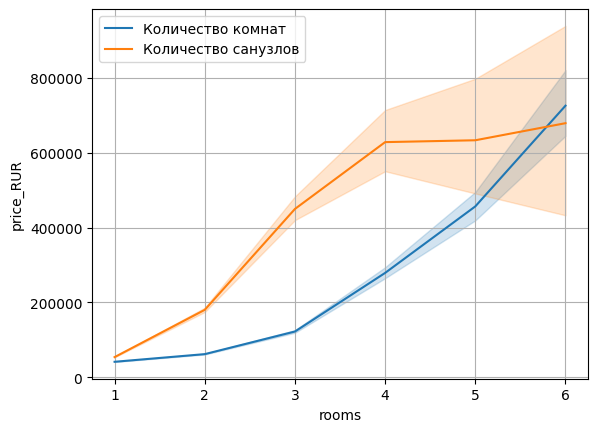

In [27]:
sns.lineplot(data=df2, y='price_RUR', x='rooms', label='Количество комнат')
sns.lineplot(data=df2, y='price_RUR', x='bathrooms', label='Количество санузлов')
plt.grid()

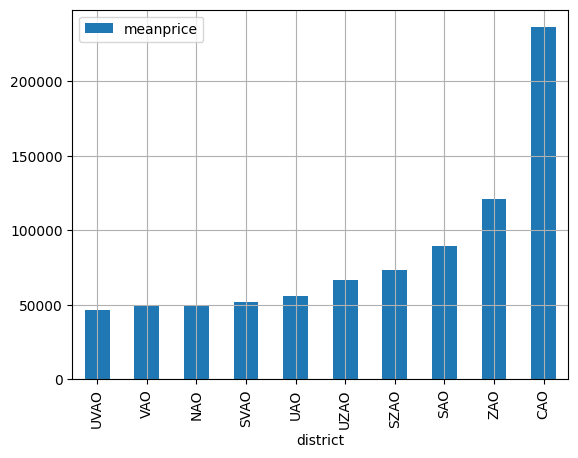

In [28]:
df2.groupby("district").agg(meanprice = ("price_RUR","mean")).sort_values(by ="meanprice").plot.bar()
plt.grid()

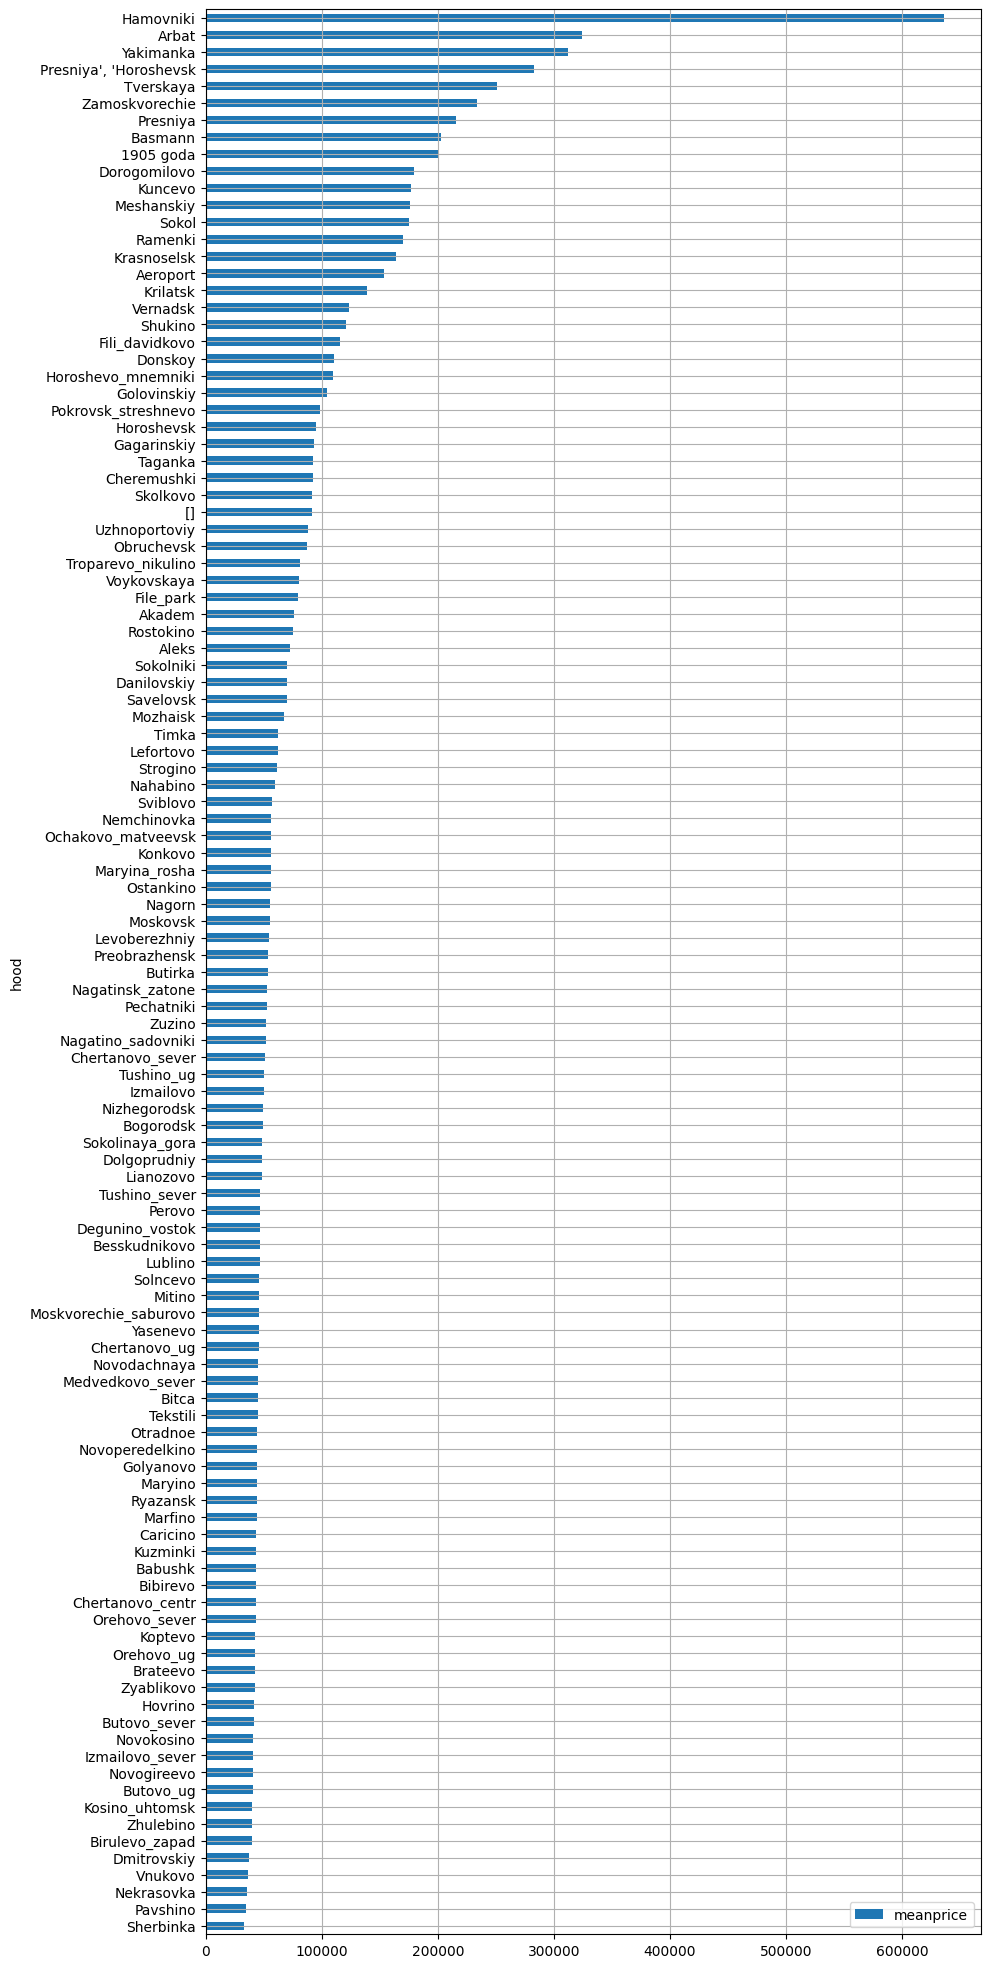

In [29]:
df2.groupby("hood").agg(meanprice = ("price_RUR","mean")).sort_values(by ="meanprice").plot.barh(figsize=(10,25))
plt.grid()

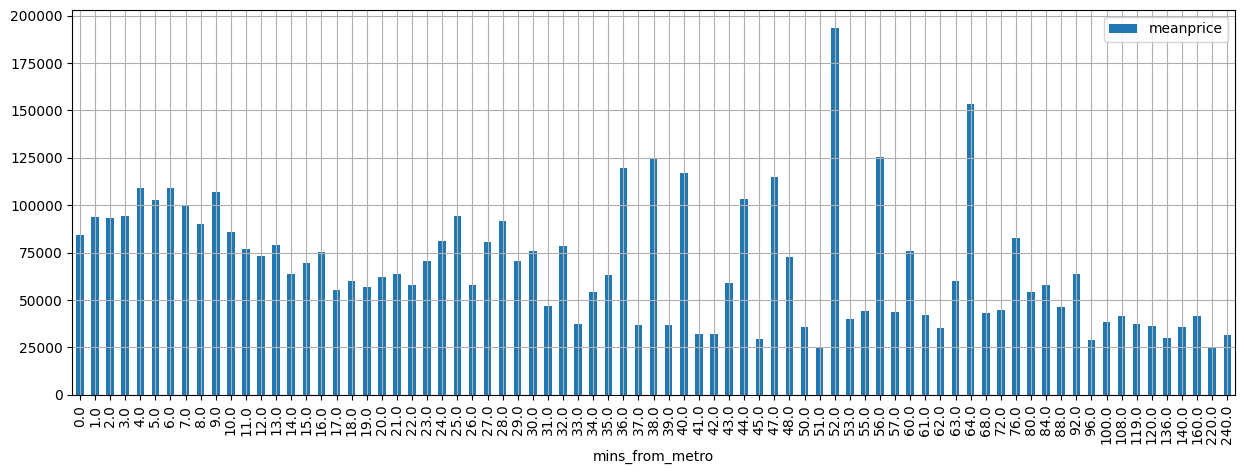

In [30]:
df2.groupby("mins_from_metro").agg(meanprice = ("price_RUR","mean")).plot(kind = "bar", figsize=(15,5))
plt.grid()

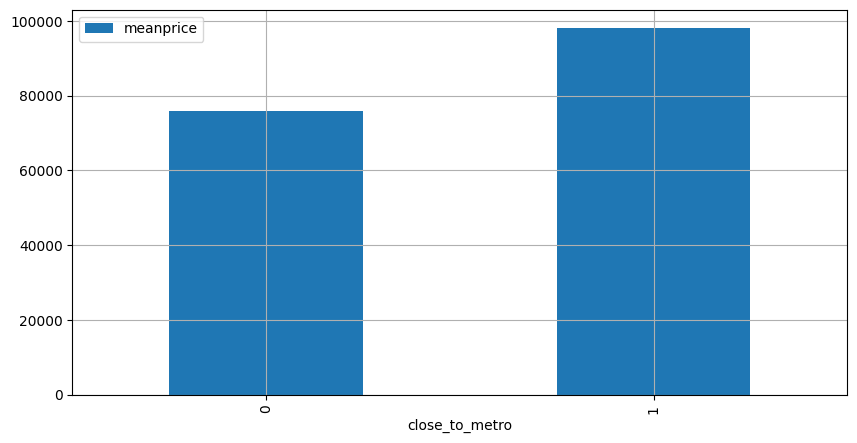

In [31]:
df2.groupby("close_to_metro").agg(meanprice = ("price_RUR","mean")).plot(kind = "bar", figsize=(10,5))
plt.grid()

<Axes: xlabel='district'>

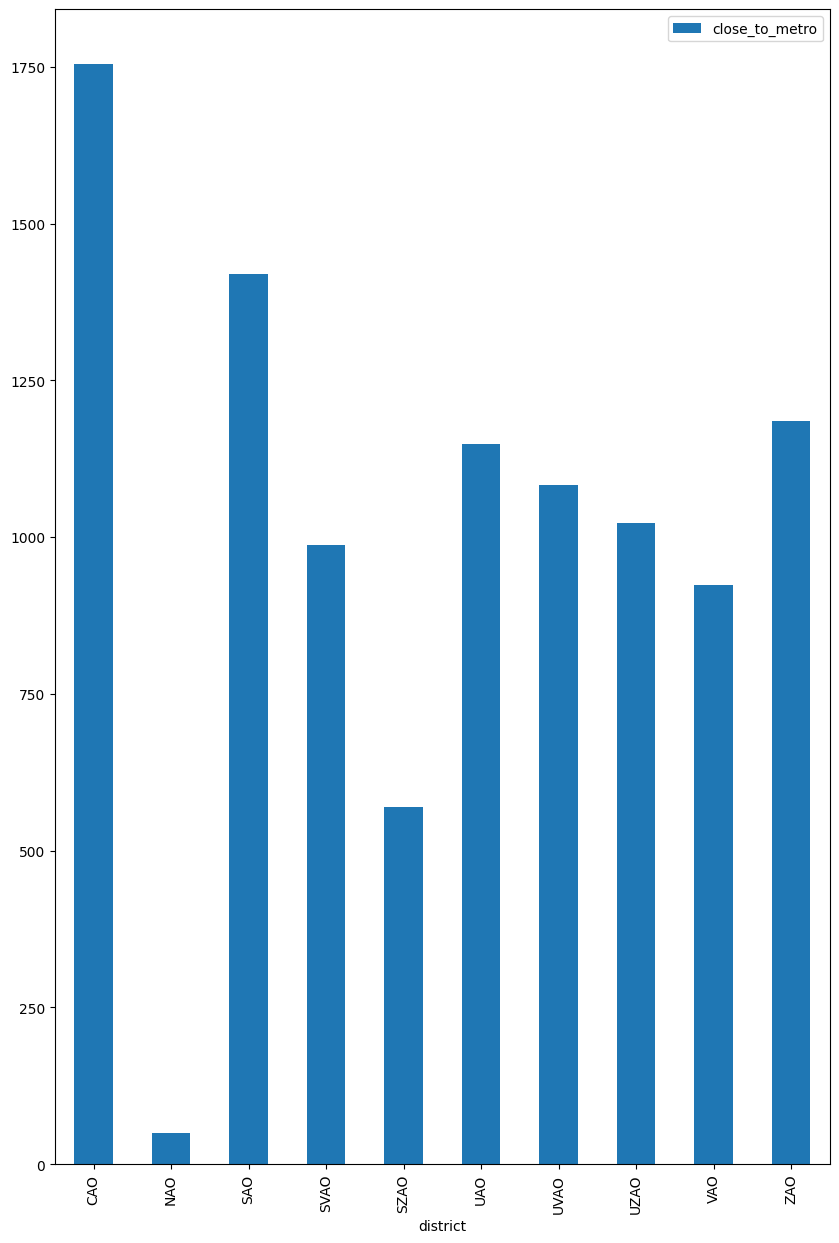

In [39]:
df2.groupby("district")[["close_to_metro"]].sum().plot.bar(figsize= (10,15))
